In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
np.random.seed(1000)

# BIAS FRAME

In [3]:
singleimg = np.random.normal(size=(201,201),loc=1000,scale=6)

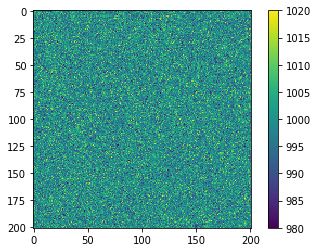

In [4]:
plt.imshow(singleimg,interpolation='none')
plt.clim([980,1020])
plt.colorbar();

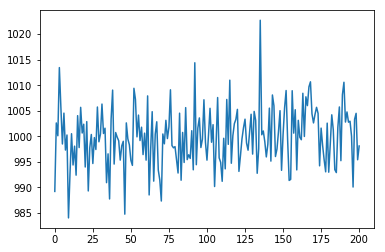

In [5]:
plt.plot(singleimg[100,:]);

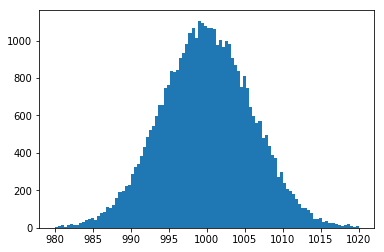

In [6]:
plt.hist(singleimg.flatten(),range=((980,1020)),bins=100);

In [7]:
imgs = np.random.normal(size=(201,201,30),loc=1000,scale=6)
imgmed = np.median(imgs,axis=2)

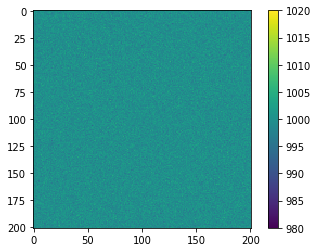

In [8]:
plt.imshow(imgmed,interpolation='none')
plt.clim([980,1020])
plt.colorbar();

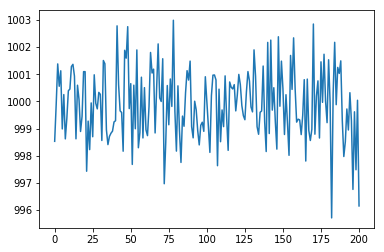

In [9]:
plt.plot(imgmed[100,:]);

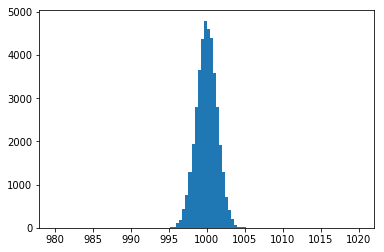

In [10]:
plt.hist(imgmed.flatten(),range=((980,1020)),bins=100);

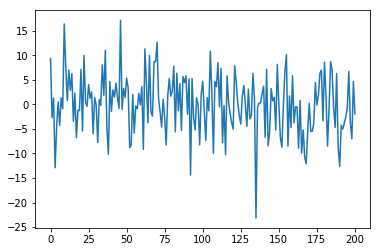

In [11]:
plt.plot(imgmed[100,:]-singleimg[100,:]);

# DARK FRAME

In [49]:
singleimg = np.random.poisson(size=(201,201),lam=10)

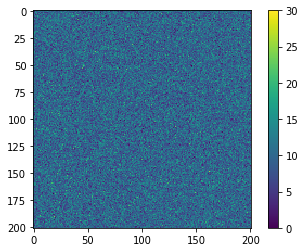

In [56]:
plt.imshow(singleimg,interpolation='none')
plt.clim([0,30])
plt.colorbar();

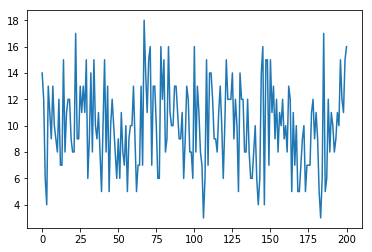

In [55]:
plt.plot(singleimg[100,:]);

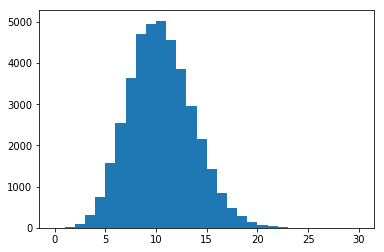

In [58]:
plt.hist(singleimg.flatten(),range=((0,30)),bins=30);

In [59]:
imgs = np.random.poisson(size=(201,201,30),lam=10)
imgmed = np.median(imgs,axis=2)

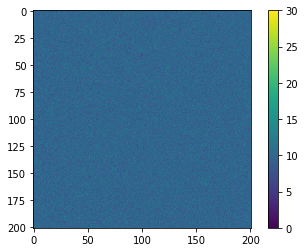

In [60]:
plt.imshow(imgmed,interpolation='none')
plt.clim([0,30])
plt.colorbar();

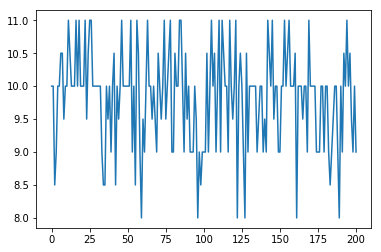

In [61]:
plt.plot(imgmed[100,:]);

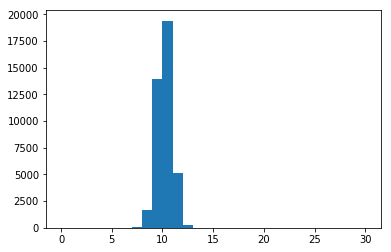

In [63]:
plt.hist(imgmed.flatten(),range=((0,30)),bins=30);

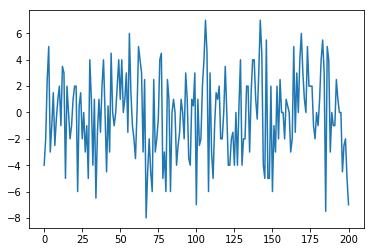

In [64]:
plt.plot(imgmed[100,:]-singleimg[100,:]);

# SIMULATED OBSERVATION 

Note: Flat fielding is not included in this simulation

In [66]:
readnoise = 6 #e-
background = 10 #e- (sky background)
darkcurrent = 10 #e-
biasoffset = 1000 #e- (offset value set by electronics)
size = 201

bias = np.random.normal(size=(size,size),loc=biasoffset,scale=readnoise)
bkg = np.random.poisson(size=(size,size),lam=background)
dark = np.random.poisson(size=(size,size),lam=darkcurrent)

allbias = np.random.normal(size=(size,size,20),loc=biasoffset,scale=readnoise)
masterbias = np.median(allbias,axis=2)

alldark = np.random.poisson(size=(size,size,20),lam=darkcurrent)
masterdark = np.median(alldark,axis=2)

In [13]:
def gaussianimg(size, x0, y0, intensity, sigma):
    img = np.zeros((size,size))
    totflux = 0
    for i in range(size):
        for j in range(size):
            val = intensity*math.exp(-4*math.log(2) * ((i-x0)**2 + (j-y0)**2) / sigma**2)
            totflux += val
            img[i,j] = np.random.poisson(lam=val)
    print('Total True Flux: %f'%totflux)        
    return(img)

In [93]:
brightness = 100
width = 4
myobs = gaussianimg(201,100,100,brightness,width) + bias + bkg + dark - masterbias - masterdark

Total True Flux: 1812.944057


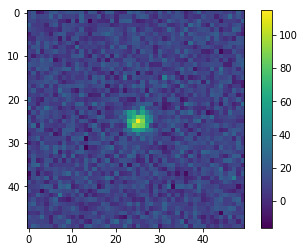

In [94]:
plt.imshow(myobs[75:125,75:125],interpolation='none')
plt.colorbar();

In [69]:
def aperturephot(img,x,y,dr):
    dbinner = 15
    dbouter = 20
    drmax = 25
 
    appix = 0.0
    nappix = 0.0
    bkgpix = 0.0
    nbkgpix = 0.0
    
    bkgpixval = []
    
    for i in np.arange(x-drmax,x+drmax):
        for j in np.arange(y-drmax,y+drmax):
            if((i-x)**2+(j-y)**2<=dr**2):
                appix += img[i,j]
                nappix += 1 
            if(((i-x)**2+(j-y)**2<=dbouter**2) and ((i-x)**2+(j-y)**2>dbinner**2)):
                bkgpix += img[i,j]
                bkgpixval.append(img[i,j])
                nbkgpix += 1
    
    flux = appix - bkgpix*(nappix/nbkgpix)
    
    return(flux,bkgpix/nbkgpix,nappix,nbkgpix,np.var(np.array(bkgpixval),ddof=1))

In [95]:
fluxvals = np.zeros(13)
bkgvals = np.zeros(13)
nappix = np.zeros(13)
nbkgpix = np.zeros(13)
bkgvarvals = np.zeros(13)

for i in range(len(fluxvals)):
    fluxvals[i],bkgvals[i],nappix[i],nbkgpix[i],bkgvarvals[i] = aperturephot(myobs,100,100,i)

Total Flux: 1715.162837


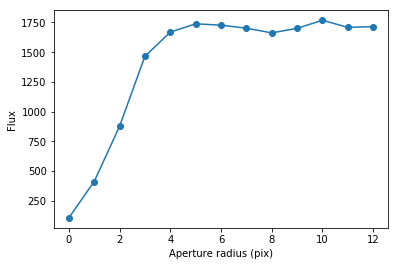

In [96]:
plt.plot(fluxvals,'o-')
plt.xlabel('Aperture radius (pix)')
plt.ylabel('Flux')
print('Total Flux: %f'%fluxvals[12])

# SNR of Aperture Photometry

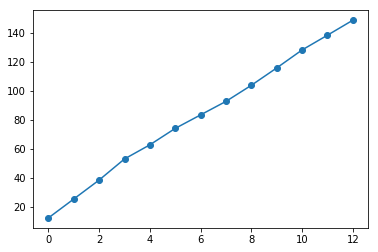

In [97]:
noise = np.sqrt(fluxvals + nappix*(bkgvals + readnoise**2)+(nappix/(nbkgpix*1.0))*(bkgvals + readnoise**2))
plt.plot(noise,'o-')

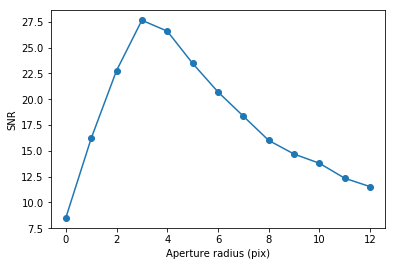

In [98]:
snra = fluxvals/np.sqrt(fluxvals + nappix*(bkgvals + readnoise**2)+(nappix/(nbkgpix*1.0))*(bkgvals + readnoise**2))
plt.plot(snra,'o-')
plt.xlabel('Aperture radius (pix)')
plt.ylabel('SNR');

In [74]:
correction = fluxvals[3]/fluxvals[12]
print('Aperture Correction: %f'%correction)

Aperture Correction: 1.500385


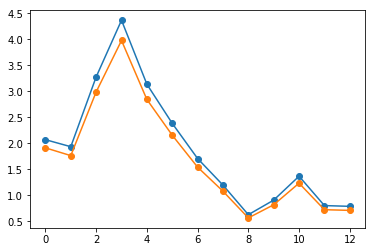

In [75]:
snrb = fluxvals/np.sqrt(fluxvals+nappix*bkgvarvals+(nappix/(nbkgpix*1.0))*bkgvarvals)
plt.plot(snra,'o-')
plt.plot(snrb,'o-');

In [76]:
estflux = fluxvals[3]/correction
print('Estimated Flux: %f' % estflux)

Estimated Flux: 113.162837
